In [1]:
import pandas as pd

# Dataframe creation

In [2]:
data = pd.read_csv('/Users/mikel/Documents/Projects/chameleon-pricing/twb_data.csv', sep=",", skiprows=3)

In [3]:
data=data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 65'])

In [4]:
data=pd.DataFrame(data.T)

In [5]:
indice = data.index[1:]

In [6]:
aux = pd.DataFrame(data.iloc[0])

In [7]:
final = pd.DataFrame(data = data.iloc[1:], index = indice, columns= list(aux['Country Name']))

In [8]:
last = data.iloc[1:]

In [9]:
df=last.rename(columns=dict(data.iloc[0]))

In [10]:
#Quitamos todas aquellas columnas y filas con full nulls
df=df.dropna(axis = 0, how = 'all')
df=df.dropna(axis = 1, how = 'all')

In [11]:
#fill old null values with first occurrence
df=df.fillna(method='backfill')

In [49]:
df.Spain

1990    0.619435
1991    0.640726
1992    0.668489
1993    0.682646
1994    0.694306
1995    0.713594
1996    0.724042
1997    0.723932
1998    0.723853
1999    0.739210
2000    0.739549
2001    0.747416
2002    0.742312
2003    0.760047
2004    0.766530
2005    0.769508
2006    0.736983
2007    0.733300
2008    0.725862
2009    0.718152
2010    0.726370
2011    0.714129
2012    0.694976
2013    0.674800
2014    0.662359
2015    0.664740
2016    0.642644
2017    0.630839
2018    0.631944
2019    0.626031
2020    0.624484
Name: Spain, dtype: float64

# Time series

In [13]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pylab as plt

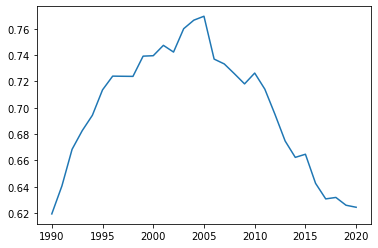

In [14]:
%matplotlib inline

df.Spain.plot();

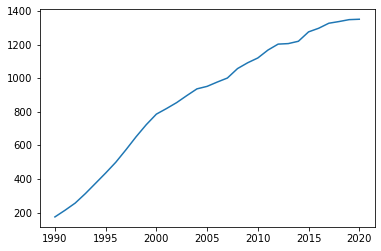

In [15]:
df.Colombia.plot();

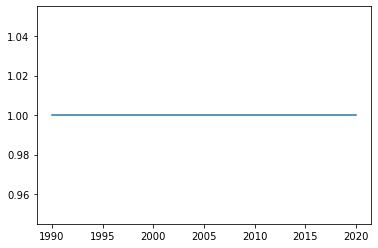

In [16]:
df['United States'].plot();

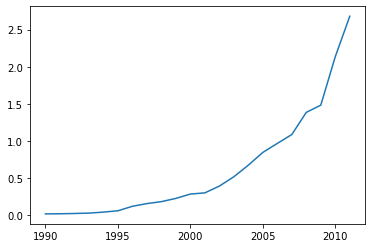

In [17]:
df['Venezuela, RB'].plot();

In [18]:
#arma 1 1 

In [19]:
df=df.fillna(method='backfill')

In [20]:
df.index = pd.to_numeric(df.index, errors='coerce')

In [21]:
for i in df:
    df[i]=df[i].interpolate(method="spline", order=1)

In [22]:
# ARMA order==> p=>AR(n, maxlag), q=MA(m, ancho de la ventana)

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error as mse

In [25]:
db = df.reset_index()

In [35]:
db['index'] =  pd.to_datetime(db['index'], format='%Y')

In [41]:
db=db.set_index('index')

In [53]:
train, test = db.Spain[:-5], db.Spain[-5:]

In [54]:
model=ARMA(train, order = (1, 1)).fit(disp=False)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [55]:
pred=model.predict(len(train), len(db.Spain)-1)

In [56]:
pred

2016-01-01    0.666634
2017-01-01    0.666995
2018-01-01    0.667335
2019-01-01    0.667655
2020-01-01    0.667955
Freq: AS-JAN, dtype: float64

In [57]:
mse(model.predict(len(train), len(db.Spain)-1), test)**0.5

0.03676322091217629

In [58]:
pred=model.predict(len(train), len(db.Spain)-1)
error=(pred-test).abs().sum()/len(pred)
print('Error mae: ', error.round(5))
res=pd.DataFrame({'real': test, 'pred': pred, 'diff':pred-test})
res

Error mae:  0.03613


,real,pred,diff
2016-01-01,0.642644,0.666634,0.023990
2017-01-01,0.630839,0.666995,0.036156
2018-01-01,0.631944,0.667335,0.035391
2019-01-01,0.626031,0.667655,0.041624
2020-01-01,0.624484,0.667955,0.043471
